In [ ]:
import torch.nn.functional as F

In [ ]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "pSBCepRZtfO4jxJIbmjITNb8X"

# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl
# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
#assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"



In [ ]:
!wget https://raw.githubusercontent.com/youssefmmagdy/Music_Generator/main/irish.abc

In [ ]:
import os
import regex as re
import numpy as np
import tensorflow as tf

from IPython.display import Audio


cwd = os.getcwd()  # Use getcwd() instead of __file__


def load_training_data():
    with open(os.path.join(cwd, "data", "irish.abc"), "r") as f:
        text = f.read()
    songs = extract_song_snippet(text)
    return songs


def extract_song_snippet(text):
    pattern = r"(^|\n\n)(.*?)\n\n"
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs


def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    with open(save_name, "w") as f:
        f.write(song)
    return filename


def abc2wav(abc_file):
    path_to_tool = os.path.join(cwd, "bin", "abc2wav")
    cmd = "{} {}".format(path_to_tool, abc_file)
    return os.system(cmd)


def play_wav(wav_file):
    return Audio(wav_file)


def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename + ".abc")
    if ret == 0:  # did not suceed
        return play_wav(basename + ".wav")
    return None

def play_generated_song(generated_text):
    songs = extract_song_snippet(generated_text)
    if len(songs) == 0:
        print(
            "No valid songs found in generated text. Try training the \
            model longer or increasing the amount of generated music to \
            ensure complete songs are generated!"
        )

    for song in songs:
        play_song(song)
    print(
        "None of the songs were valid, try training longer to improve \
        syntax."
    )


In [ ]:
# Download the dataset
text = open('irish.abc', 'r').read()
songs = extract_song_snippet(text)

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [ ]:
vocab = sorted(set(''.join(songs)))
vocab_size = len(vocab)
songs_joined = '\n\n'.join(songs)


In [ ]:
char2idx = {s:i for i, s in enumerate(vocab)}
idx2char = np.array(vocab)

In [ ]:
vectorized_songs = np.array([char2idx[i] for i in songs_joined])
n = len(vectorized_songs) - 1

In [ ]:
def get_batch(vectorized_songs, seq_length, batch_size):
    rand = torch.randint(0, n-seq_length, (batch_size,))

    input_batch = [vectorized_songs[i:i+seq_length] for i in rand]

    output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in rand]

    x_batch = torch.tensor(input_batch, dtype=torch.long)

    y_batch = torch.tensor(output_batch, dtype=torch.long)

    return x_batch, y_batch


In [ ]:
class LSTMDemo(nn.Module):
    def __init__(self, vocab_size, n_emb, hidden_size):
        super(LSTMDemo, self).__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, n_emb)
        self.lstm = nn.LSTM(n_emb, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state with zeros
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))

    def forward(self, x, state=None, return_state=False):
        x = self.emb(x)

        if state is None:
            state = self.init_hidden(x.shape[0], x.device)

        out, state = self.lstm(x, state)

        out = self.linear(out)

        return out if not return_state else (out, state)


In [ ]:
batch_size = 32
seq_length = 100
n_emb = 256
hidden_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

x, y = get_batch(vectorized_songs, seq_length, batch_size)
x = x.to(device)
y = y.to(device)

model = LSTMDemo(vocab_size, n_emb, hidden_size).to(device)

pred = torch.softmax(model(x), dim=-1)

cpu


In [ ]:
pred = torch.softmax(model(x), dim=-1)
sampled_indices = torch.multinomial(torch.softmax(pred[0], dim=-1), num_samples=1)
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()
''.join([idx2char[i] for i in sampled_indices.squeeze().tolist()])

'Z^]1a(m=R:I^ec_)zS2qHWM6nT<Ey,,8kL.0tlpw_6A#Z:1.3]bE3ET)AU72fo"F(lK\n\'F1p::UIr_SA>LnGfm> mj_38S7elRbk'

In [ ]:
''.join([idx2char[i] for i in sampled_indices.squeeze().tolist()])

'Z^]1a(m=R:I^ec_)zS2qHWM6nT<Ey,,8kL.0tlpw_6A#Z:1.3]bE3ET)AU72fo"F(lK\n\'F1p::UIr_SA>LnGfm> mj_38S7elRbk'

In [ ]:
y.shape, pred.shape

(torch.Size([32, 100]), torch.Size([32, 100, 83]))

In [ ]:
loss = F.cross_entropy(pred.view(pred.shape[0] * pred.shape[1], pred.shape[2]),
                 y.view(y.shape[0] * y.shape[1]))
loss

tensor(4.4187, grad_fn=<NllLossBackward0>)

In [ ]:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  hidden_size = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
model = LSTMDemo(vocab_size, params['embedding_dim'], params['hidden_size'])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

def train_step(x, y):
    model.train()
    optimizer.zero_grad()

    # forward
    y_hat = model(x)
    # logits = torch.softmax(y_hat, dim=-1)
    loss = F.cross_entropy(y_hat.view(y_hat.shape[0] * y_hat.shape[1], y_hat.shape[2]),
                 y.view(y.shape[0] * y.shape[1]))

    # backward step
    loss.backward()

    # update step
    optimizer.step()

    return loss


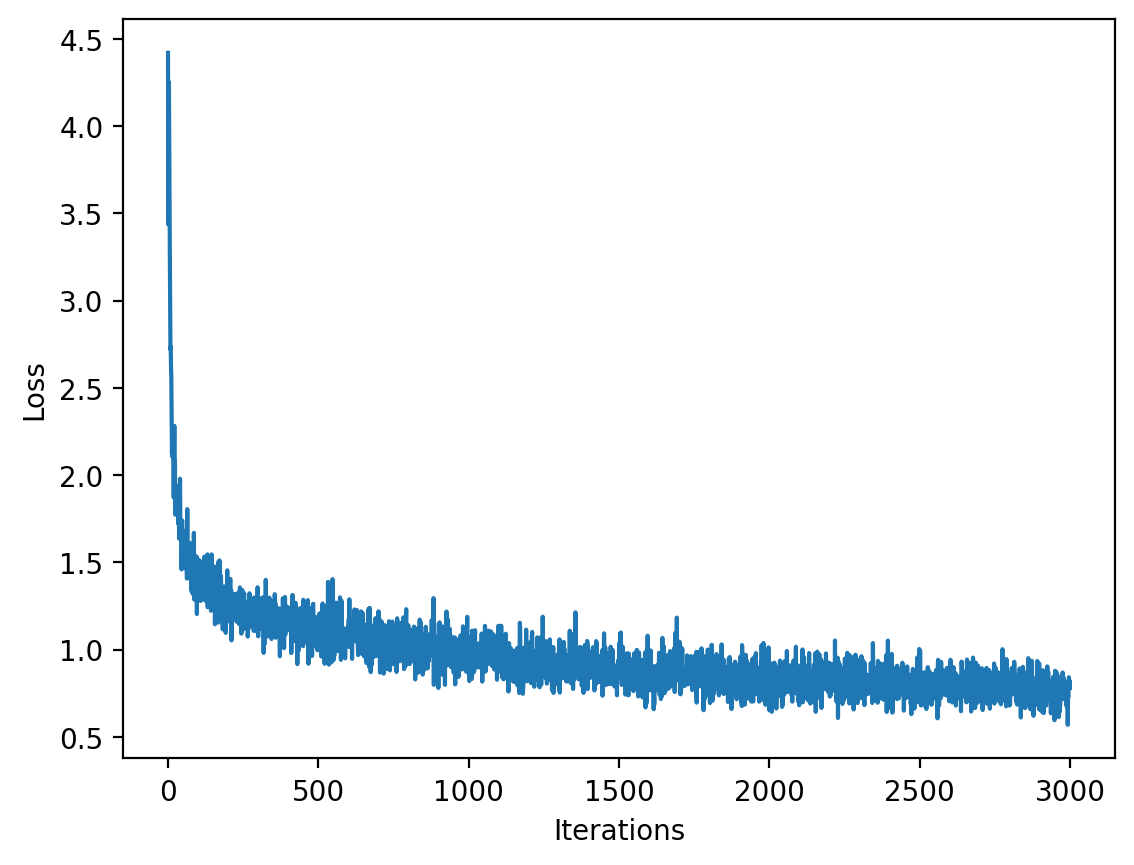

100%|██████████| 3000/3000 [50:32<00:00,  1.01s/it]


True

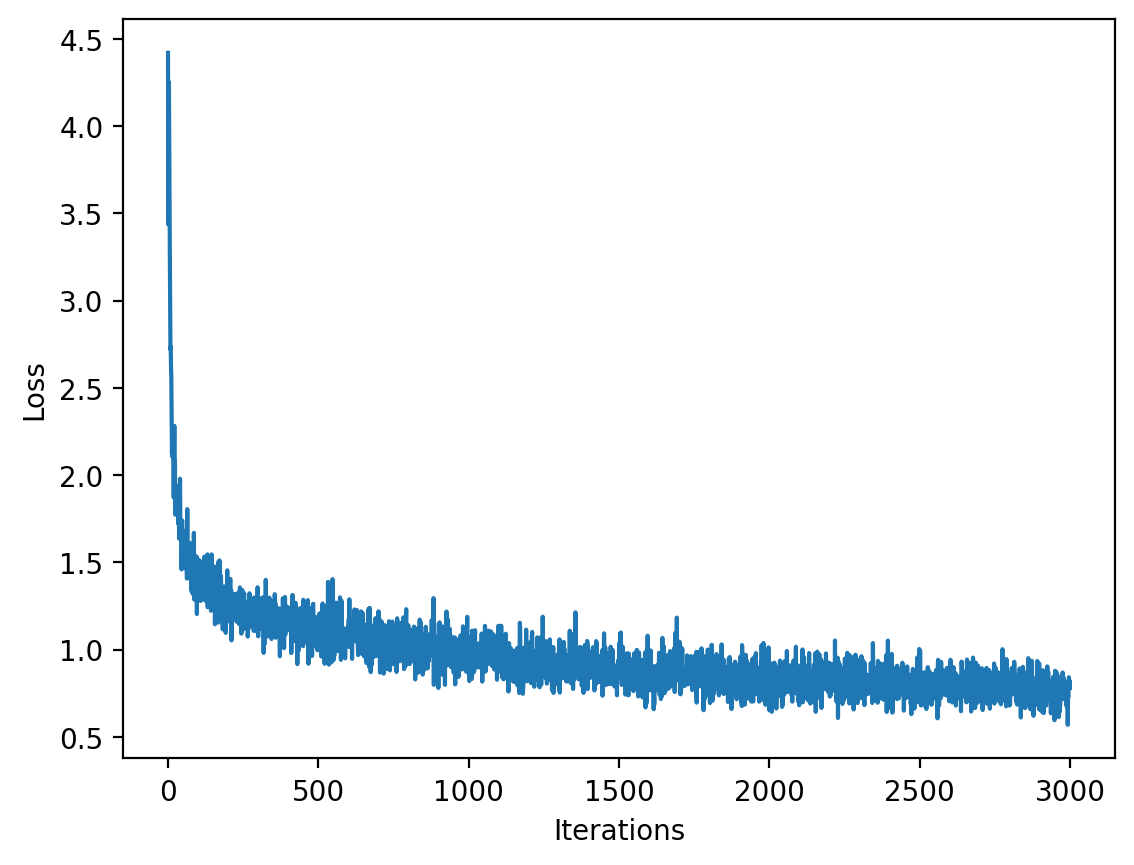

In [ ]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])

    # Convert numpy arrays to PyTorch tensors
    x_batch = torch.tensor(x_batch, dtype=torch.long)
    y_batch = torch.tensor(y_batch, dtype=torch.long)

    # Take a train step
    loss = train_step(x_batch, y_batch)

    # Log the loss to the Comet interface
    experiment.log_metric("loss", loss.item(), step=iter)

    # Update the progress bar and visualize within notebook
    history.append(loss.item())
    plotter.plot(history)

    # Save model checkpoint
    if iter % 100 == 0:
        torch.save(model.state_dict(), checkpoint_prefix)

# Save the final trained model
torch.save(model.state_dict(), checkpoint_prefix)
experiment.flush()

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_idx = [char2idx[s] for s in start_string] # TODO
  # input_idx = ['''TODO''']
  input_idx = torch.tensor([input_idx], dtype=torch.long).to(device)

  # Initialize the hidden state
  state = model.init_hidden(input_idx.size(0), device)

  # Empty string to store our results
  text_generated = []
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
    '''TODO: evaluate the inputs and generate the next character predictions'''
    predictions, state = model(input_idx, state, return_state=True)
    # predictions, hidden_state = model('''TODO''', '''TODO''', return_state=True)

    # Remove the batch dimension
    predictions = predictions.squeeze(0)

    '''TODO: use a multinomial distribution to sample over the probabilities'''
    input_idx = torch.multinomial(torch.softmax(predictions, dim=-1), num_samples=1)
    # input_idx = torch.multinomial('''TODO''', dim=-1), num_samples=1)

    '''TODO: add the predicted character to the generated text!'''
    # Hint: consider what format the prediction is in vs. the output
    text_generated.append(idx2char[input_idx].item()) # TODO
    # text_generated.append('''TODO''')


  return start_string + ''.join(text_generated)

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', '''TODO''', '''TODO''')

In [ ]:
with open("tmp.abc", "w") as f:
    f.write(generated_text.replace('\n', '\n'))

In [ ]:
from music21 import converter

### Play back generated songs ###

generated_songs = extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)
  print(waveform)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

In [ ]:
experiment.end()